# Fraud Detection Analysis
This notebook analyzes credit card transaction data to detect fraudulent activities.

## 1. Setup and Imports
### Import required libraries and set up initial configurations

In [ ]:
# Import dependencies
import pandas as pd
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import os

In [2]:
# # Set plotting style with seaborn
# plt.style.use('seaborn')
# sns.set_palette("husl")

# Set plotting style using a built-in matplotlib style
plt.style.use('bmh')  # or 'ggplot', 'classic', 'dark_background', etc.
# Alternative to sns.set_palette using matplotlib
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#FF4B4B', '#4B4BFF', '#4BFF4B', '#FFB74B'])

## 2. Helper Functions
Define utility functions for data processing and analysis

In [3]:
def extract_time_features(df):
    """Extract time-based features from transaction datetime."""
    df = df.copy()
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    
    # Basic time features
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day'] = df['trans_date_trans_time'].dt.day
    df['month'] = df['trans_date_trans_time'].dt.month
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
    
    # Additional time features
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['time_period'] = pd.cut(df['hour'], 
                              bins=[-1, 6, 12, 18, 24], 
                              labels=[0, 1, 2, 3])
    df['is_business_hours'] = df['hour'].between(9, 17).astype(int)
    
    return df

In [4]:
def prepare_data(df):
    """Prepare dataset by creating features and dropping unnecessary columns."""
    # Create time features first
    df = extract_time_features(df)
    
    # Drop unnecessary columns
    columns_to_drop = [
        'Unnamed: 0', 'merchant', 'cc_num', 'category', 'first', 'last', 
        'gender', 'street', 'city', 'state', 'lat', 'long', 'city_pop', 
        'job', 'dob', 'trans_num', 'unix_time', 'trans_date_trans_time'
    ]
    
    return df.drop(columns=columns_to_drop)

## 3. Data Loading

1. Setup path to Kaggle Data and import the fraud detection datasets 
2. Load and prepare the training and test datasets
3. Define paths to training and test CSV files
 

In [6]:
path = kagglehub.dataset_download("kartik2112/fraud-detection")

fraud_test_csv = r"C:\Users\Jean\.cache\kagglehub\datasets\kartik2112\fraud-detection\versions\1\fraudTest.csv"
fraud_train_csv = r"C:\Users\Jean\.cache\kagglehub\datasets\kartik2112\fraud-detection\versions\1\fraudTrain.csv"
# Load data
fraud_test_df = pd.read_csv(fraud_test_csv)
fraud_train_df = pd.read_csv(fraud_train_csv)

# Prepare data
train_df = prepare_data(fraud_train_df)
test_df = prepare_data(fraud_test_df)

# Display basic information
print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
train_df.head()


Training set shape: (1296675, 12)
Test set shape: (555719, 12)


,amt,zip,merch_lat,merch_long,is_fraud,hour,day,month,day_of_week,is_weekend,time_period,is_business_hours
0,4.97,28654,36.011293,-82.048315,0,0,1,1,1,0,0,0
1,107.23,99160,49.159047,-118.186462,0,0,1,1,1,0,0,0
2,220.11,83252,43.150704,-112.154481,0,0,1,1,1,0,0,0
3,45.00,59632,47.034331,-112.561071,0,0,1,1,1,0,0,0
4,41.96,24433,38.674999,-78.632459,0,0,1,1,1,0,0,0


## 4. Exploratory Data Analysis (EDA)
### 4.1 Basic Data Analysis

In [7]:
# Display basic statistics
print("Training set statistics:")
print(train_df.describe())

# Check for missing values
print("\nMissing values in training set:")
print(train_df.isnull().sum())

Training set statistics:
                amt           zip     merch_lat    merch_long      is_fraud  \
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06   
mean   7.035104e+01  4.880067e+04  3.853734e+01 -9.022646e+01  5.788652e-03   
std    1.603160e+02  2.689322e+04  5.109788e+00  1.377109e+01  7.586269e-02   
min    1.000000e+00  1.257000e+03  1.902779e+01 -1.666712e+02  0.000000e+00   
25%    9.650000e+00  2.623700e+04  3.473357e+01 -9.689728e+01  0.000000e+00   
50%    4.752000e+01  4.817400e+04  3.936568e+01 -8.743839e+01  0.000000e+00   
75%    8.314000e+01  7.204200e+04  4.195716e+01 -8.023680e+01  0.000000e+00   
max    2.894890e+04  9.978300e+04  6.751027e+01 -6.695090e+01  1.000000e+00   

               hour           day         month   day_of_week    is_weekend  \
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06   
mean   1.280486e+01  1.558798e+01  6.142150e+00  3.070604e+00  3.482260e-01   
std    6.817824e+00  8.829

### 4.2 Fraud Distribution Analysis

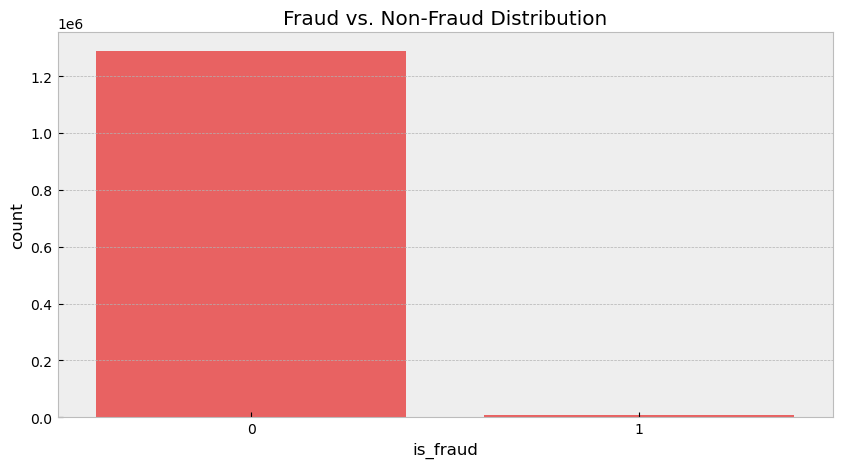

Percentage of fraudulent transactions: 0.58%


In [8]:
# Plot fraud distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='is_fraud', data=train_df)
plt.title('Fraud vs. Non-Fraud Distribution')
plt.show()

# Calculate fraud percentage
fraud_percentage = (train_df['is_fraud'].sum() / len(train_df)) * 100
print(f"Percentage of fraudulent transactions: {fraud_percentage:.2f}%")


### 4.3 Time-Based Analysis

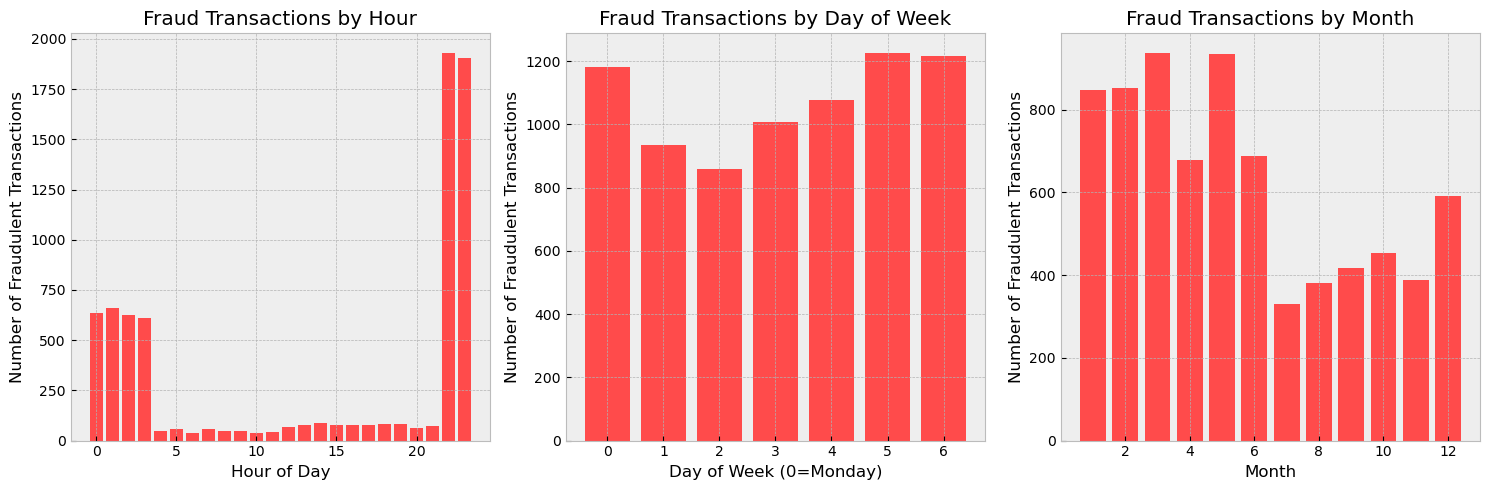

In [9]:
def plot_time_patterns(df):
    """Visualize fraud patterns across different time features."""
    plt.figure(figsize=(15, 5))
    
    # Fraud by hour
    plt.subplot(1, 3, 1)
    fraud_by_hour = df[df['is_fraud'] == 1]['hour'].value_counts().sort_index()
    plt.bar(fraud_by_hour.index, fraud_by_hour.values)
    plt.title('Fraud Transactions by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Fraudulent Transactions')
    
    # Fraud by day of week
    plt.subplot(1, 3, 2)
    fraud_by_dow = df[df['is_fraud'] == 1]['day_of_week'].value_counts().sort_index()
    plt.bar(fraud_by_dow.index, fraud_by_dow.values)
    plt.title('Fraud Transactions by Day of Week')
    plt.xlabel('Day of Week (0=Monday)')
    plt.ylabel('Number of Fraudulent Transactions')
    
    # Fraud by month
    plt.subplot(1, 3, 3)
    fraud_by_month = df[df['is_fraud'] == 1]['month'].value_counts().sort_index()
    plt.bar(fraud_by_month.index, fraud_by_month.values)
    plt.title('Fraud Transactions by Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Fraudulent Transactions')
    
    plt.tight_layout()
    plt.show()

# Plot time patterns
plot_time_patterns(train_df)

### 4.4 Transaction Amount Analysis

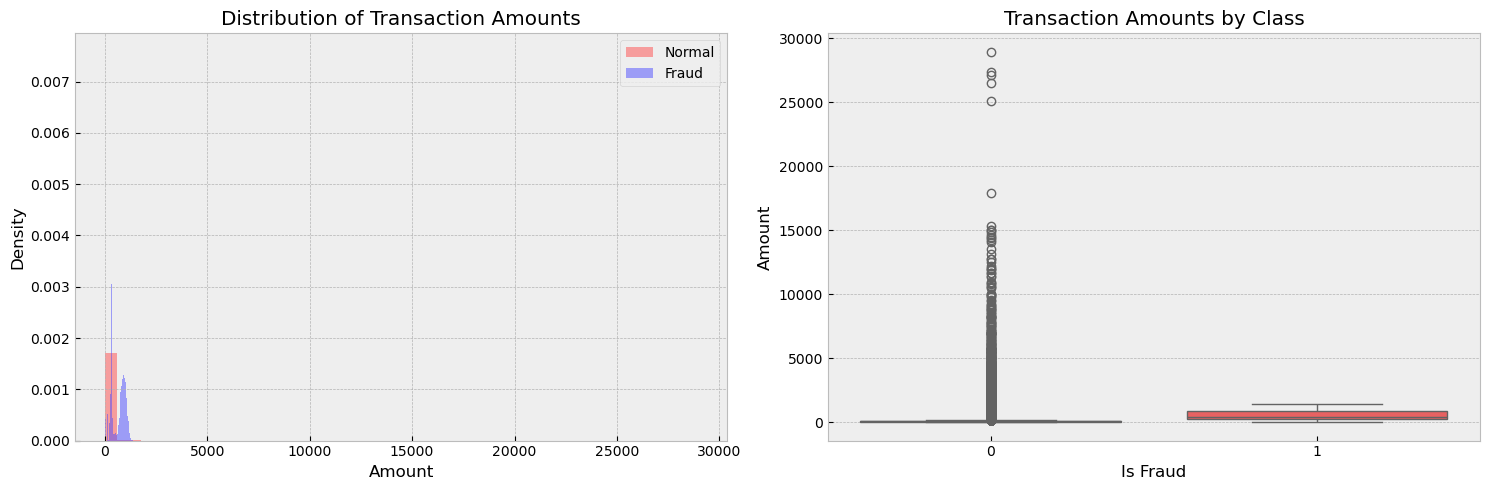

In [10]:
def plot_amount_analysis(df):
    """Analyze and visualize transaction amounts."""
    plt.figure(figsize=(15, 5))
    
    # Distribution of transaction amounts
    plt.subplot(1, 2, 1)
    plt.hist(df[df['is_fraud'] == 0]['amt'].values, 
             bins=50, alpha=0.5, label='Normal', density=True)
    plt.hist(df[df['is_fraud'] == 1]['amt'].values, 
             bins=50, alpha=0.5, label='Fraud', density=True)
    plt.title('Distribution of Transaction Amounts')
    plt.xlabel('Amount')
    plt.ylabel('Density')
    plt.legend()
    
    # Box plot of amounts
    plt.subplot(1, 2, 2)
    sns.boxplot(x='is_fraud', y='amt', data=df)
    plt.title('Transaction Amounts by Class')
    plt.xlabel('Is Fraud')
    plt.ylabel('Amount')
    
    plt.tight_layout()
    plt.show()

# Plot amount analysis
plot_amount_analysis(train_df)

## 5. Model Development
### 5.1 Data Preparation for Modeling

In [18]:
# Prepare features and target
X_train = train_df.drop('is_fraud', axis=1)
y_train = train_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']

### 5.2 Create Model Pipeline for Logistic Regression

In [19]:
def create_model_pipeline():
    """Create a preprocessing and modeling pipeline."""
    # Define numeric features
    numeric_features = ['amt', 'hour', 'day', 'month', 'day_of_week', 
                       'is_weekend', 'time_period', 'is_business_hours']
    
    # Create preprocessor
    numeric_transformer = StandardScaler()
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)
        ])
    
    # Create pipeline
    return Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=1))
    ])

In [20]:
# Create and train model
model = create_model_pipeline()
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amt', 'hour', 'day',
                                                   'month', 'day_of_week',
                                                   'is_weekend', 'time_period',
                                                   'is_business_hours'])])),
                ('classifier', LogisticRegression(random_state=1))])

### 5.3 Model Evaluation of Logistic Regression

In [57]:
def evaluate_model(y_true, y_pred):
    """Evaluate model performance."""
    # Print confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(
        cm, 
        index=["Actual 0", "Actual 1"], 
        columns=["Predicted 0", "Predicted 1"]
    )
    print("\nConfusion Matrix of Logistic Regression:")
    print(cm_df)
    
    # Print classification report
    print("\nClassification Report of Logistic Regression:")
    print(classification_report(y_true, y_pred))
    
    # Print ROC AUC score
    print("\nROC AUC Score of Logistic Regression:", roc_auc_score(y_true, y_pred))

# Make predictions and evaluate
y_pred_LR = model.predict(X_test)
evaluate_model(y_test, y_pred_LR)


Confusion Matrix of Logistic Regression:
          Predicted 0  Predicted 1
Actual 0       553260          314
Actual 1         2145            0

Classification Report of Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.00      0.00      0.00      2145

    accuracy                           1.00    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      1.00      0.99    555719


ROC AUC Score of Logistic Regression: 0.49971638841419574


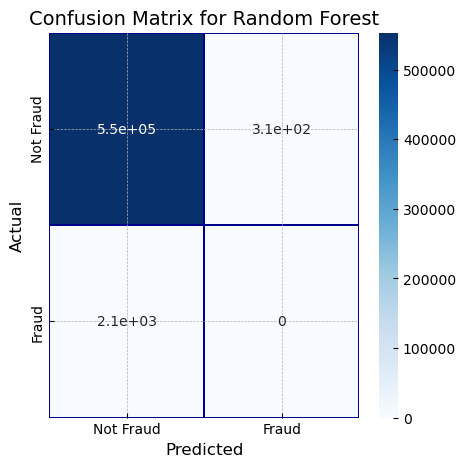

In [64]:
# Create confusion matrix of results
cm_lr = pd.crosstab(y_test.values, y_pred_LR, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm_lr, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix for Random Forest', fontsize=14)
plt.show()

### 5.4 Create Random Forester Model

In [33]:
# Create the RandomForestClassifier
# For the sae of this project, use a lower number of trees. More trees increases accuracy, but make learning slower)

clf_rf = RandomForestClassifier(n_estimators=10, verbose=3)

In [34]:
# Training the model on the training dataset

clf_rf.fit(X_train, y_train)


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


RandomForestClassifier(n_estimators=10, verbose=3)

In [35]:
# performing predictions on the test dataset
y_pred_rf = clf_rf.predict(X_test)

### 5.5 Model Evaluation of Random Forest Classifier

In [56]:
# using metrics module for accuracy calculation
print("ACCURACY OF THE RANDOM FOREST MODEL:", metrics.accuracy_score(y_test, y_pred_rf))

ACCURACY OF THE RANDOM FOREST MODEL: 0.9968635227516065


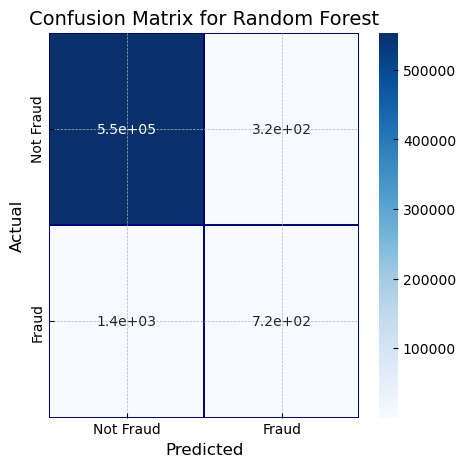

In [61]:
# Create confusion matrix of results
cm_rf = pd.crosstab(y_test.values, y_pred_rf, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm_rf, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix for Random Forest', fontsize=14)
plt.show()

In [54]:
# Print the classification report for the model
print("Classification Report for Random Forest")
print(classification_report(y_test, y_pred_rf))

Classification Report for Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.69      0.34      0.45      2145

    accuracy                           1.00    555719
   macro avg       0.85      0.67      0.73    555719
weighted avg       1.00      1.00      1.00    555719



In [58]:
# Print ROC AUC score
print("\nROC AUC Score of Random Forest:", roc_auc_score(y_test, y_pred_rf))


ROC AUC Score of Random Forest: 0.6673127463484309


### 5.6 Create Model for Ada Boost Classifier

In [40]:
# Prepare the Ada Boost Classifier Model
clf_ab = AdaBoostClassifier()

In [41]:
# Fit the model
clf_ab.fit(X_train, y_train)

AdaBoostClassifier()

In [42]:
# Make predictions
y_pred_ab = clf_ab.predict(X_test)

### 5.7 Model Evaluation of Ada Boost Classifier

In [53]:
# Print the accuracy score
print("The accuracy of the Ada Boost model on validation set is", clf_ab.score(X_test,y_test))

The accuracy of the Ada Boost model on validation set is 0.9969534962813941


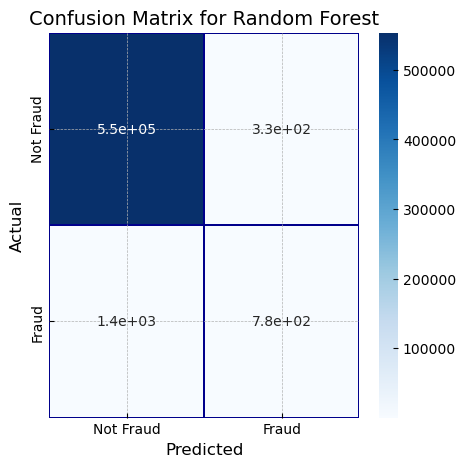

In [62]:
# Create confusion matrix of results
cm_ab = pd.crosstab(y_test.values, y_pred_ab, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm_ab, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix for Random Forest', fontsize=14)
plt.show()

In [51]:
# Print the classification report for the model
print("Classification Report of Ada Boost")
print(classification_report(y_test, y_pred_ab))

Classification Report of Ada Boost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.70      0.37      0.48      2145

    accuracy                           1.00    555719
   macro avg       0.85      0.68      0.74    555719
weighted avg       1.00      1.00      1.00    555719



In [59]:
# Print ROC AUC score
print("\nROC AUC Score of Ada Boost:", roc_auc_score(y_test, y_pred_ab))


ROC AUC Score of Ada Boost: 0.6824507131757834


## 6. Conclusions and Next Steps
# 
Key findings from our analysis:
- [Add our conclusions here]
# 
Potential improvements:
1. Try different models (Random Forest, XGBoost)
2. Handle class imbalance (SMOTE, class weights)
3. Feature selection
4. Hyperparameter tuning
5. Add more advanced features